# Taxi Gym Environment

https://www.gymlibrary.dev/environments/toy_text/taxi/

### Handle imports

In [53]:
import numpy as np
import gym
from gym.wrappers import RecordVideo
import os
import random
import imageio
#Get progress bars
from tqdm.notebook import trange

#Video
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [54]:
#Make our taxi environment
env = gym.make("Taxi-v3")
print("Observation Space ", env.observation_space)
print("Sample observation", env.observation_space.sample()) #Display a random observation

Observation Space  Discrete(500)
Sample observation 212


In [55]:
#Print action space shape and sample
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample())

Action Space Shape 6
Action Space Sample 3


### Create and Initialize the Q-table

The Q-Table has columns as actions, and rows as states. We can use OpenAI Gym to find action space and state space. We will then use this information to create the Q-Table. 

In [56]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  500  possible states
There are  6  possible actions


There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.

Each state space is represented by the tuple: (taxi_row, taxi_col, passenger_location, destination)

In [57]:
#Create a numpy array of 500 x 6 for our q table
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

Qtable_taxi = initialize_q_table(state_space, action_space)
Qtable_taxi

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

## Epsilon Greedy Policy


In [58]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    random_int = random.uniform(0,1)
    if(random_int > epsilon):
        action = np.argmax(Qtable[state])
    else:
        action = env.action_space.sample()
    return action


In [59]:
def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state])
  return action

## Hyperparameters Tuning

In [60]:
#Training parameters
n_training_episodes = 10000
learning_rate = 0.7

#Evaluation parameters
n_eval_episodes = 100

#Environment parameters
env_id = "Taxi-v3"
max_steps = 99
gamma = 0.95
eval_seed = []

#Exploration parametrs
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0005

## Do our model training

In [61]:
def train_agent(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    #For each episode in our episodes
    for episode in trange(n_training_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        #Reset our environment
        state = env.reset()
        step = 0
        done = False
        
        #Repeat up to the max steps for this episode 
        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            
            new_state, reward, done, info = env.step(action)
            
            #Update our qtable
            Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])
            
            #If done, break out of the episode
            if done:
                break
            
            #Update new state
            state = new_state
            
    return Qtable

In [62]:
Qtable_taxi = train_agent(n_training_episodes, min_epsilon,max_epsilon,decay_rate,env,max_steps, Qtable_taxi)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [63]:
Qtable_taxi

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 2.75200369,  3.94947757,  2.75200369,  3.94947757,  5.20997639,
        -5.05052243],
       [ 7.93349184,  9.40367562,  7.93349184,  9.40367562, 10.9512375 ,
         0.40367562],
       ...,
       [10.9512207 , 12.58025   , 10.95122071,  9.4036694 ,  1.9491938 ,
         1.95123139],
       [ 5.20997639,  6.53658843,  5.20997639,  6.53681725, -3.7906295 ,
        -3.79002361],
       [16.1       , 14.295     , 16.1       , 18.        ,  7.1       ,
         7.1       ]])

### Run an evaluation of our policy

In [64]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    episode_rewards = []
    for episode in trange(n_eval_episodes):
        if seed:
            state = env.reset(seed = seed[episode])
        else:
            state = env.reset()
            
        step = 0
        done = False
        total_rewards_ep = 0
        
        for step in range(max_steps):
            #Take the action that has maximum reward
            action = np.argmax(Q[state][:])
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward
            
            if done:
                break
            
            state = new_state
        episode_rewards.append(total_rewards_ep)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward          

In [65]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_taxi, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=7.78 +/- 2.51


In [66]:
def record_video(env, Qtable, out_directory, fps = 1):
    images = []
    done = False
    state = env.reset(seed = random.randint(0,500))
    img = env.render(mode = 'rgb_array')
    images.append(img)
    
    while not done:
        #Take the action index that have the maximum expected future reward given that state
        action = np.argmax(Qtable[state][:])
        state, reward, done, info = env.step(action) #Directly put next state - state for recording logic
        img = env.render(mode = 'rgb_array')
        images.append(img)
        
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)] , fps = fps)

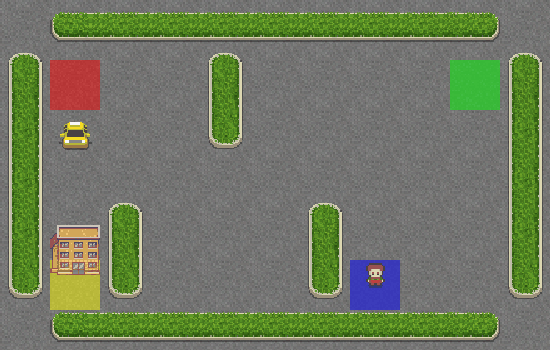

In [67]:
video_path= os.getcwd() + "/content/taxireplay.gif"
video_fps=1
record_video(env, Qtable_taxi, video_path, video_fps)

from IPython.display import Image
Image(os.getcwd() + "/content/taxireplay.gif")

# Make a video for it

In [68]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [69]:
env = RecordVideo(gym.make("Taxi-v3"), "./video")
state = env.reset(seed = 11250)
while True:
    env.render()
    #your agent goes here
    action = np.argmax(Qtable_taxi[state])
    new_state, reward, done, info = env.step(action)
    state = new_state
    if done:
      break;
env.close()
show_video()